# Sentiment Analysis

## Libraries

In [21]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import kagglehub
import os
import re
import gc

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import load_model

## Dataset

In [22]:
# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140", path="training.1600000.processed.noemoticon.csv")
print(path)

100%|██████████| 80.9M/80.9M [00:00<00:00, 96.5MB/s]

Extracting zip of training.1600000.processed.noemoticon.csv...


/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv


In [23]:
column_names = ["target", "id", "date", "query", "user", "text"]
df = pd.read_csv(path, encoding='latin-1', names=column_names)
df.drop(columns=["id", "date", "query", "user"], inplace=True)

# Keep only negative (0) and positive (4) tweets
df = df[df["target"] != 2]

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display cleaned data
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [24]:
# Keep only negative (0) and positive (4) tweets
df = df[df["target"] != 2]

# Map labels: 0 → 0 (Negative), 4 → 1 (Positive)
df["target_mapped"] = df["target"].map({0: 0, 4: 1})

# Display cleaned data
df.head()

,target,text,target_mapped
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,is upset that he can't update his Facebook by ...,0
2,0,@Kenichan I dived many times for the ball. Man...,0
3,0,my whole body feels itchy and like its on fire,0
4,0,"@nationwideclass no, it's not behaving at all....",0


In [25]:
# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [26]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [27]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions

    # Remove only unwanted characters, but keep punctuation and some emoticon characters.
    # This pattern keeps letters, numbers, whitespace, and these punctuation marks: !?.,:;()'-"
    text = re.sub(r"[^a-zA-Z0-9\s!?.,:;()'\-\"\[\]]", "", text)

    # Optionally, you could tokenize and then selectively remove stopwords,
    # but consider that sometimes stopwords in tweets can affect the sentiment context.
    words = text.split()
    return " ".join(words)


# Apply preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)
df.head()

,target,text,target_mapped,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,- a that's a bummer. you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,0,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,0,i dived many times for the ball. managed to sa...
3,0,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",0,"no, it's not behaving at all. i'm mad. why am ..."


In [28]:
# Extract features and labels
X = df["clean_text"].values
y = df["target_mapped"].values


In [29]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Tokenize the text data
vocab_size = 10000  # Limit vocabulary size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length (maxlen can be adjusted)
maxlen = 70
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

## Model/Training (Skip to Inference/Test if you only want to experiment)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))

# Add Global Max Pooling for better feature extraction
model.add(GlobalMaxPooling1D())

# Dense layers with dropout to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,
    batch_size=16392,
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.6294 - loss: 0.6465 - val_accuracy: 0.7899 - val_loss: 0.4576
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 352ms/step - accuracy: 0.7948 - loss: 0.4557 - val_accuracy: 0.8032 - val_loss: 0.4277
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.8060 - loss: 0.4301 - val_accuracy: 0.8081 - val_loss: 0.4165
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.8119 - loss: 0.4163 - val_accuracy: 0.8096 - val_loss: 0.4123
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.8162 - loss: 0.4068 - val_accuracy: 0.8151 - val_loss: 0.4038
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 353ms/step - accuracy: 0.8212 - loss: 0.3974 - val_accuracy: 0.8172 - val_loss: 0.3996
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.8250 - loss: 0.3901 - val_accuracy: 0.8182 - val_loss: 0.3982
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 352ms/step - accuracy: 0.8270 - loss: 0.3860 - val_accu

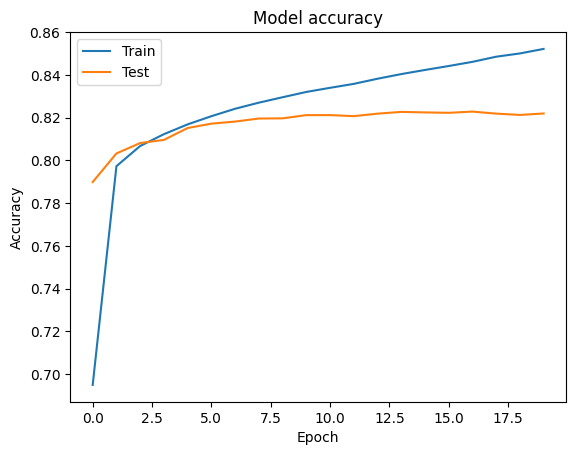

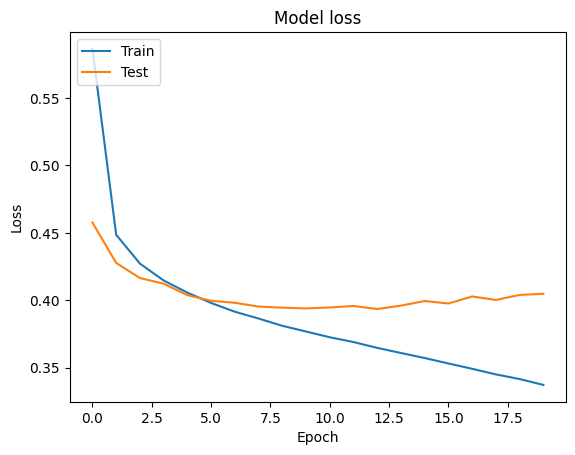

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Save the entire model to a Keras file
model.save('standard.keras')

## Inference/Testing

In [32]:
# Load the model

loaded_model = load_model(os.path.join(os.getcwd(), 'standard.keras'))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [85]:
# Define a mapping from numerical output to sentiment label
sentiment_map = {0: "Negative", 1: "Positive"}

def infer_sentiment(text):
    """
    Takes a raw text string, preprocesses it, and returns the sentiment prediction.
    """
    # Preprocess the text (using the same preprocessing as during training)
    processed_text = preprocess_text(text)

    # Tokenize the text.
    seq = tokenizer.texts_to_sequences([processed_text])

    # Pad the sequence to the same length used during training
    padded_seq = pad_sequences(seq, maxlen=maxlen, padding='post')

    # Get prediction probabilities from the model
    pred_probs = loaded_model.predict(padded_seq)
    pred_prob = pred_probs[0][0]

    print("Sentiment:", sentiment_map[round(pred_prob)])
    print("Negative-Positive Scale: 0 - Most Negative / 100 - Most Positive):")
    print("Point on the Negative-Positive Scale = ", round(pred_prob*100))


    return

In [87]:
# Example usage:
example_text = "I enjoyed this movie in ways I cannot describe. The actors did an amazing job!"
infer_sentiment(example_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sentiment: Positive
Negative-Positive Scale: 0 - Most Negative / 100 - Most Positive):
Point on the Negative-Positive Scale =  97


In [88]:
example_text = "I kind of got bored from walking, not a very nice day!"
infer_sentiment(example_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sentiment: Negative
Negative-Positive Scale: 0 - Most Negative / 100 - Most Positive):
Point on the Negative-Positive Scale =  12


In [90]:
example_text = "I hate how much I love this series, can't wait for the next episode!"
infer_sentiment(example_text)
#On this hard test prompt, it almost got it right!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sentiment: Negative
Negative-Positive Scale: 0 - Most Negative / 100 - Most Positive):
Point on the Negative-Positive Scale =  46


In [92]:
example_text = "Feel free to change this and try your sentence!"
infer_sentiment(example_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sentiment: Positive
Negative-Positive Scale: 0 - Most Negative / 100 - Most Positive):
Point on the Negative-Positive Scale =  100
